In [1]:
import os
import sys
work_dir = os.path.dirname(os.path.dirname(os.path.abspath('.')))
os.chdir(work_dir)
sys.path.append(os.path.join(work_dir,'src'))
sys.path.append(work_dir)
import numpy as np
import matplotlib.pyplot as plt
from approaches.method import Net
import torch_geometric.transforms as T
import torch
import yaml
from brain_data import HemiBrain
import os.path as osp
import random
import networkx as nx

In [2]:
config='/data/users/wgj/project/NDGNN_Neurips22_Realeased/runs/NDGNN_demo_model/Sep05_11-17-08_amax/config.yaml'
model_para='/data/users/wgj/project/NDGNN_Neurips22_Realeased/runs/NDGNN_demo_model/Sep05_11-17-08_amax/checkpoint_best_model.pt'

with open(config,'r') as fin:
    task=yaml.load(fin)


task['type_dim']=5555
model=Net(task)
checkpoint=torch.load(model_para)
model.load_state_dict(checkpoint.state_dict())
model.cpu()


/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


Net(
  (Deco): LinkPred(
    (predictor): joint_predictor(
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): Dropout(p=0.5, inplace=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=256, out_features=64, bias=True)
      )
      (lin1): Linear(in_features=64, out_features=1, bias=True)
    )
    (nei_encoder): NeighEnco2(
      (lookupneigh): Lookup_neighbor_embedding()
      (conv1): Conv1d(64, 32, kernel_size=(1,), stride=(1,), bias=False)
      (act_f1): LeakyReLU(negative_slope=0.05)
      (dp1): Dropout(p=0.5, inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      (act_f2): LeakyReLU(negative_slope=0.05)
      (dp2): Dropout(p=0.5, inplace=True)
    )
  )
  (node_Enco): GCN(
    (node_attr_layer): node_attr_encoder(
      (drop1): Dropout(p=0.5, inplace=True)
    )
    (conv1): GCNConv(100, 128)
    (relu1): ReLU()
    (drop1): Dropout(p=0.5, inplace=True)
    (conv2): G

In [3]:

path = osp.join('data', task['Experiment'])
train_split='/data/users/wgj/project/NDGNN_Neurips22_Realeased/runs/NDGNN_demo_model/Sep05_11-17-08_amax/train_data.dt'
test_split='/data/users/wgj/project/NDGNN_Neurips22_Realeased/runs/NDGNN_demo_model/Sep05_11-17-08_amax/test_data.dt'
train_data=HemiBrain(path,transform=None,restore_split=train_split)

test_data=HemiBrain(path,transform=None,restore_split=test_split)
x=train_data.data.x.cpu()
edge_index=train_data.data.edge_index.cpu()
z=model.node_Enco(x=x,edge_index=edge_index)


In [4]:
emb=z.detach().numpy()
torch.save(z,'Plot_figure/Main_content/emb.pt')


In [5]:
from sklearn.manifold import TSNE
X_fit=TSNE(n_components=2,init='pca').fit_transform(emb)
label=train_data.data.y.cpu().numpy().T
print(label.shape)



(21739,)


In [6]:
k=19
label_count={}
for i in label:
    if i in label_count:
        label_count[i]+=1
    else:
        label_count[i]=1
label_sort=sorted(label_count.items(),key=lambda x:x[1],reverse=True)
label_count=label_sort[:500]

topklabel=[i[0] for i in label_count]
res=np.transpose(X_fit)
x,y=res[0],res[1]
colors=['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']+['#9b5de5', '#f15bb5', '#fee440', '#00bbf9', '#00f5d4']+['#5f0f40', '#9a031e', '#fb8b24', '#e36414', '#0f4c5c']

color_dict={k:c for k,c in enumerate(colors)}
ccc=[]
marke=[]
for l in label:
    g=l%k
    if g in color_dict:
        ccc.append(color_dict[g])
    else:
        ccc.append('grey')
    marke.append(r'$%d$'%l)


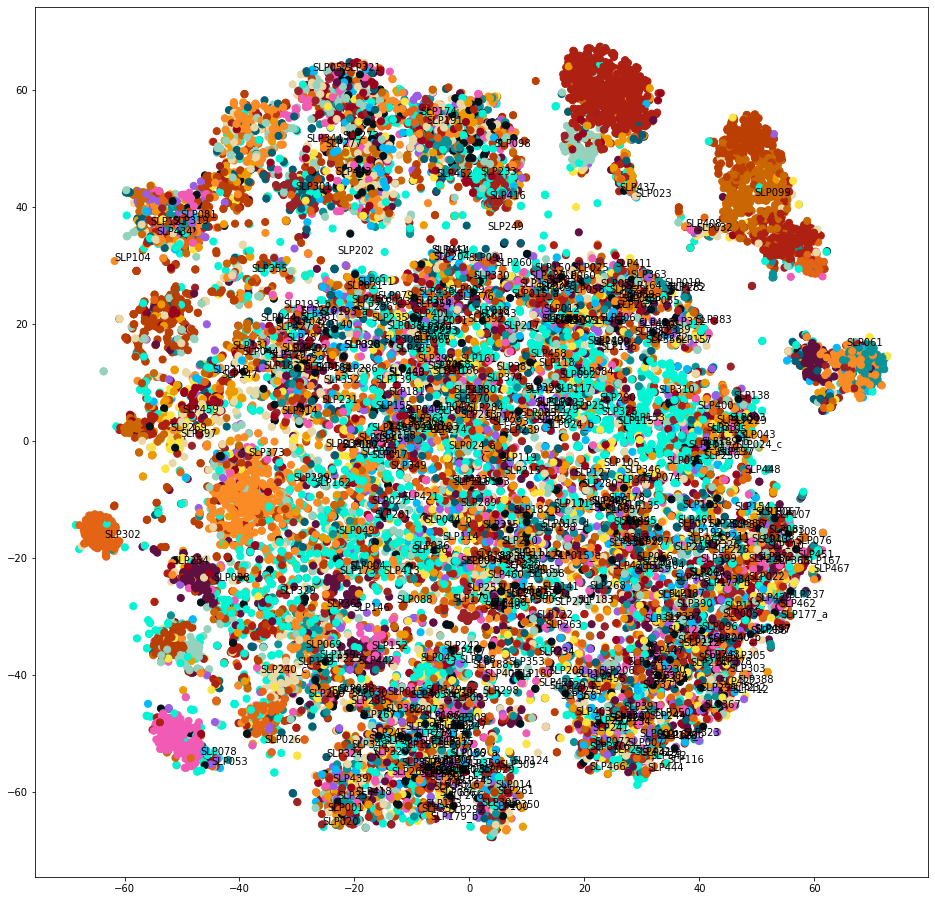

In [7]:
pos={}
for k,n in enumerate(X_fit):
    if label[k] in pos:
        pos[label[k]].append(n)
    else:
        pos[label[k]]=[n]

center_pos={}
text_x=[]
text_y=[]
text=[]
for k,v in pos.items():
    v=np.array(v)
    center_pos[k]=np.mean(v,axis=0)

    text_x.append(center_pos[k][0])
    text_y.append(center_pos[k][1])
    text.append(k)

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(16,16))
y2label={v:k for k,v in train_data.label2ID.items()}
for k,t in enumerate(text):
    if 'SLP' in y2label[t]:
        ax.annotate(y2label[t],(text_x[k],text_y[k]))
ax.scatter(x,y,c=ccc,s=50)
fig.savefig(os.path.join(work_dir,'Plot_figure/Main_content','NDGNN-%s-tnse.png'%task['Experiment']))

In [8]:
from utils import edge_index2Graph
from brain_data import LinkPred_PairNeigh_Loader
from torch_geometric.transforms import RandomLinkSplit
from tqdm import tqdm
num_neuron=z.shape[0]
g=torch.ones(size=(num_neuron,num_neuron))-torch.eye(num_neuron)
g=g.to_sparse().indices()
# dataset2=HemiBrain(path,transform=RandomLinkSplit(num_val=task['val'], num_test=task['test'],
#                             add_negative_train_samples=False))
# train_data,_,_=dataset2[0]
nxg=edge_index2Graph(edge_index)
nxg.to_undirected()
loader=LinkPred_PairNeigh_Loader(task,train_data,nxg)

#nxg_neighbors=train_loader.get_neighboor()



In [9]:
model.eval()
index_loader=torch.split(g,100000,dim=1)
res=[]
with torch.no_grad():
    for bat in tqdm(index_loader):
        batch=bat.cpu()
        if model.use_pair_enco:
            neighbors=loader.get_neighboor(batch,max_num=4)
            neighbors=neighbors.contiguous()
            out=model.Deco(z,batch,neighbor=neighbors)
        else:
            out=model.Deco(z,batch)
        res.append(out)


100%|██████████| 4726/4726 [3:46:56<00:00,  2.88s/it]  


In [10]:
pred_graph_logits=torch.cat(res,dim=0)
torch.save(pred_graph_logits,'Plot_figure/Main_content/pred_graph_logits-%f.pt'%(random.random()))

